In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

import sys
sys.path.append("../templates/slow_extraction_tutorial")
import plot_helpers

### Import CNAO Lattice to Xsuite

In [3]:
line = xt.Line.from_json('../templates/PIMMStutorials_CNAOlattice/cnao_lattice_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/429 [00:00<?, ?it/s]

Done loading line from dict.           


### Set tunes, chromaticities and zero dispersion at symmetry point

In [4]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-3, dqy=-1, tol=1e-3, tag="chrom"), # horizontal chromaticity for Hardt Condition
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 2             
Matching: model call n. 36               
Optimize - end penalty:  4.38821e-07


### Generate and track particles

In [5]:
# Generate 20 particles on the x axis
x_gen = np.linspace(0, 2.5e-2, 20)
particles = line.build_particles(x=x_gen,px=0,y=0,py=0,delta=0)

# Track selected number of turns logging turn-by-turn data
num_turns = 2000
line.track(particles,num_turns=num_turns, turn_by_turn_monitor=True)
rec = line.record_last_track

# Compute normalized coordinates
tw = line.twiss(method='4d')
nc = tw.get_normalized_coordinates(rec)

/home/aefstrat/miniforge3/lib/python3.12/site-packages/xtrack/twiss.py:3238: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


### Define arrays to store data

In [6]:
# Get continuous longitudinal position of each element for 3 turns
s = []

s1 = line.get_table()['s']
s2 = s1[-1] + s1
s3 = s2[-1] + s1

s.extend(s1)
s.extend(s2)
s.extend(s3)

In [7]:
# Create empty arrays to store data for different deltas
separatrix = []
norm_separatrix = []

triangle_x = []
triangle_px = []
norm_triangle_x = []
norm_triangle_px = []

points_x = []
points_px = []
norm_points_x = []
norm_points_px = []

areas = []
slopes = []
delta = []
septum_px = []

### Calculate and plot quantities for different initial delta

In [8]:
for d_gen in range(0, 10):

    d_gen *= 1e-4

    ###################
    # Find Separatrix #
    ###################

    tw = line.twiss(method='4d')

    # Sepratrix search region
    search_region = [0, 0.03]
    
    # Mark septum position
    x_septum = 3.5e-2

    # Set prefered precision for search area according to horizontal tune
    if tw.qx > 1.6661 and tw.qx < 1.6676:
        absPrecisio = 1e-3
    elif tw.qx >= 1.6656 and tw.qx <= 1.6661:
        absPrecisio = 1e-4
    else:
        absPrecisio = 1e-6
    
    while search_region[1] - search_region[0] > absPrecisio:
        
        # Generate a particle in the middle of the region
        x_test = (search_region[0] + search_region[1]) / 2
        p = line.build_particles(x=x_test, px=0, delta=d_gen)
        
        # Track
        line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
        rec_test = line.record_last_track
        
        # Update the search region
        if (rec_test.x > x_septum).any():
            # Test particle is unstable
            # => Sepearatrix is on the right w.r.t x_test
            search_region[1] = x_test
        else:
            # Test particle is stable
            # Sepearatrix is on the left w.r.t x_test
            search_region[0] = x_test

    # We track particles at the outer edge of narrowed-down search region
    p = line.build_particles(x=search_region[1], delta=d_gen)
    line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
    rec_separ = line.record_last_track
    
    # Get corresponding normalized coordinates
    nc_separ = tw.get_normalized_coordinates(rec_separ)

    

    #####################################################
    # Measure the slope of the separatrix at the septum #
    #####################################################

    x_separ = rec_separ.x[0, :]
    px_separ = rec_separ.px[0, :]
    
    # Find turn at which particle was closer to the septum
    i_septum = np.argmin(np.abs(x_separ - x_septum))

    # Condition for the case that (i_septum + 3) > num_turns
    if (i_septum + 3) <= num_turns:
        poly_sep = np.polyfit([x_separ[i_septum + 3], x_separ[i_septum - 3]],
                                 [px_separ[i_septum + 3], px_separ[i_septum - 3]],
                                  deg=1)
    else:
        poly_sep = np.polyfit([x_separ[i_septum], x_separ[i_septum - 3]],
                                 [px_separ[i_septum], px_separ[i_septum - 3]],
                                  deg=1)
        
    dpx_dx_at_septum = poly_sep[0]

    # px where the least square straight line crosses the electrostatic septum
    px_at_septum = np.polyval(poly_sep, x_septum)

    

    ####################################
    # Plot boundary of the stable area #
    ####################################

    # We track particles at the inner edge of narrowed-down search region
    p = line.build_particles(x=search_region[0], delta=d_gen)
    line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
    rec_triang = line.record_last_track
    
    # Get corresponding normalized coordinates
    nc_triang = tw.get_normalized_coordinates(rec_triang)
    
    x_triang = rec_triang.x[0, :]
    px_triang = rec_triang.px[0, :]
    x_norm_triang = nc_triang.x_norm[0, :]
    px_norm_triang = nc_triang.px_norm[0, :]
    
    # Sort boundary coordinates with increawinf theta
    theta_triang = np.angle(x_norm_triang + 1j * px_norm_triang)
    i_sorted = np.argsort(theta_triang)
    
    x_triang = x_triang[i_sorted]
    px_triang = px_triang[i_sorted]
    x_norm_triang = x_norm_triang[i_sorted]
    px_norm_triang = px_norm_triang[i_sorted]


    
    #####################
    # Find fixed points #
    #####################

    z_triang_norm = nc_triang.x_norm[0, :] + 1j * nc_triang.px_norm[0, :]
    z_triang = rec_triang.x[0, :] + 1j * rec_triang.px[0, :]
    r_triang_norm = np.abs(z_triang_norm)
    
    # Search for the point on the triangle with the maximum amplitude
    i_fp1 = np.argmax(r_triang_norm)
    z_fp1 = z_triang_norm[i_fp1]
    r_fp1 = np.abs(z_fp1)
    
    # Search for local maximum amplitude at +/- 120 deg from the first fixed point
    mask_fp2 = np.abs(z_triang_norm - z_fp1 * np.exp(1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
    i_fp2 = np.argmax(r_triang_norm * mask_fp2)
    mask_fp3 = np.abs(z_triang_norm - z_fp1 * np.exp(-1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
    i_fp3 = np.argmax(r_triang_norm * mask_fp3)
    
    # Build array with fixed points
    x_norm_fp = z_triang_norm[[i_fp1, i_fp2, i_fp3]].real
    px_norm_fp = z_triang_norm[[i_fp1, i_fp2, i_fp3]].imag
    x_fp = z_triang[[i_fp1, i_fp2, i_fp3]].real
    px_fp = z_triang[[i_fp1, i_fp2, i_fp3]].imag

    # Compute stable area
    stable_area = 0.5*np.linalg.det([x_norm_fp, px_norm_fp, [1, 1, 1]])
    
    ###############################   
    # Append values to be plotted #
    ###############################
    
    delta.append(d_gen)
    
    separatrix.append(rec_separ)
    norm_separatrix.append(nc_separ)
    
    septum_px.append(px_at_septum)
    
    triangle_x.append(x_triang)
    triangle_px.append(px_triang)
    norm_triangle_x.append(x_norm_triang)
    norm_triangle_px.append(px_norm_triang)

    points_x.append(x_fp)
    points_px.append(px_fp)
    norm_points_x.append(x_norm_fp)
    norm_points_px.append(px_norm_fp)

    areas.append(stable_area)
    slopes.append(dpx_dx_at_septum)

  
    # Summary of the computed quantities 
    print(f"      Computed quantities for delta = {"%.0e"%(d_gen)}:\n")

    print(f'intersection_point = {(x_septum, float(px_at_septum))}')
    print(f'dpx_dx_at_septum = {"%.3e"%(dpx_dx_at_septum)}')
    print(f'stable_area = {"%.3e"%(stable_area)}\n')
    
    print(f'x_fp = {x_fp}')
    print(f'px_fp = {px_fp}')
    print(f'x_norm_fp = {x_norm_fp}')    
    print(f'px_norm_fp = {px_norm_fp}\n')

    
    d_gen /= 1e-4

      Computed quantities for delta = 0e+00:

intersection_point = (0.035, 0.0007758957506635682)
dpx_dx_at_septum = 2.683e-03
stable_area = 2.294e-06

x_fp = [ 0.00352018  0.00169703 -0.00515644]
px_fp = [-3.36753562e-04  2.74366843e-04  5.48209187e-05]
x_norm_fp = [ 0.00088562  0.00042701 -0.00129695]
px_norm_fp = [-0.0009972   0.00125522 -0.00028305]

      Computed quantities for delta = 1e-04:

intersection_point = (0.035, 0.0008046580074458282)
dpx_dx_at_septum = 2.134e-03
stable_area = 4.776e-06

x_fp = [ 0.0054702   0.00286255 -0.0070354 ]
px_fp = [-5.50150694e-04  3.31028414e-04  1.25984169e-05]
x_norm_fp = [ 0.00127796  0.00062201 -0.00186778]
px_norm_fp = [-0.00144172  0.00180812 -0.00041889]

      Computed quantities for delta = 2e-04:

intersection_point = (0.035, 0.0008328596033632755)
dpx_dx_at_septum = 3.308e-03
stable_area = 8.479e-06

x_fp = [ 0.00754994  0.00410622 -0.00909392]
px_fp = [-7.76566440e-04  3.96835871e-04 -2.97589562e-05]
x_norm_fp = [ 0.00170291  0.000

### Show Table with Computed Quantities 

In [9]:
import pandas as pd

data = {'Delta': delta,
        'Stable Areas': areas,
        'Separatrix Slopes': slopes,
        'px at septum': septum_px }

pd.set_option('display.float_format','{:.2e}'.format)

df = pd.DataFrame(data)
df

,Delta,Stable Areas,Separatrix Slopes,px at septum
0,0.00e+00,2.29e-06,2.68e-03,7.76e-04
1,1.00e-04,4.78e-06,2.13e-03,8.05e-04
2,2.00e-04,8.48e-06,3.31e-03,8.33e-04
3,3.00e-04,1.22e-05,2.72e-03,8.57e-04
4,4.00e-04,1.70e-05,2.56e-03,8.81e-04
5,5.00e-04,2.30e-05,3.21e-03,9.03e-04
6,6.00e-04,3.12e-05,2.27e-03,9.23e-04
7,7.00e-04,3.70e-05,3.25e-03,9.42e-04
8,8.00e-04,4.45e-05,4.11e-03,9.61e-04
9,9.00e-04,5.37e-05,3.62e-03,9.76e-04


In [10]:
# Maximum difference of px value at septum
max(data['px at septum']) - min(data['px at septum'])

np.float64(0.00020011394271615386)

### Plot all phase space diagrams in one figure

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


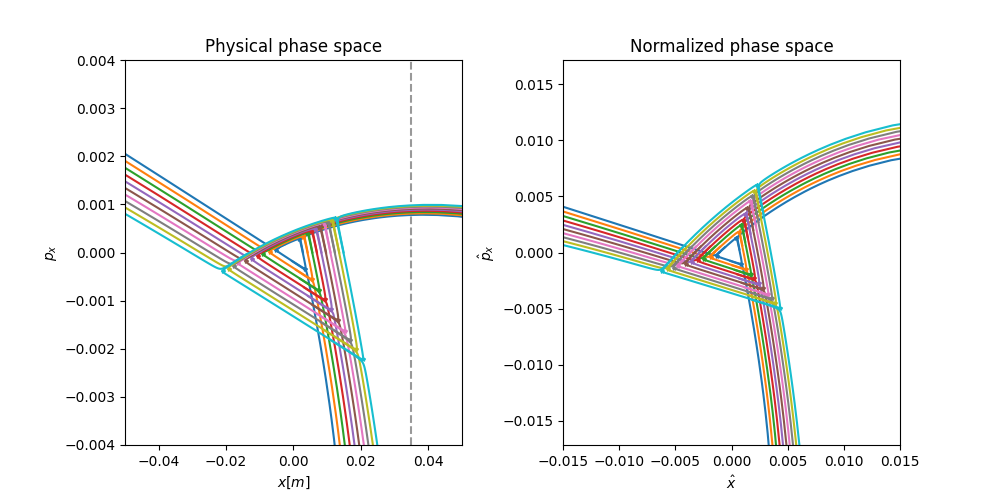

In [11]:
ax_geom, ax_norm = plot_helpers.arrange_phase_space_plot() # empty plot
ax_geom.axvline(x=x_septum, color='k', alpha=0.4, linestyle='--')
ax_geom.set_xlim(-5e-2, 5e-2); ax_geom.set_ylim(-4e-3, 4e-3)
ax_norm.set_xlim(-15e-3, 15e-3); ax_norm.set_ylim(-12e-3, 12e-3)
ax_norm.set_aspect('equal', adjustable='datalim')

colors = plt.cm.tab10.colors

for j in range(0,10):
        
    mask_alive = separatrix[j].state > 0

    color = colors[j % len(colors)]

    for ii in range(0,3):
        ax_geom.plot(separatrix[j].x[mask_alive][ii::3], separatrix[j].px[mask_alive][ii::3], '-', color=color)
        
        ax_norm.plot(norm_separatrix[j].x_norm[mask_alive][ii::3], norm_separatrix[j].px_norm[mask_alive][ii::3], '-', color=color)
    
    ax_norm.plot(norm_triangle_x[j], norm_triangle_px[j], '-', color=color)
    ax_geom.plot(triangle_x[j], triangle_px[j], '-', color=color)
    
    ax_norm.plot(norm_points_x[j], norm_points_px[j], '*', markersize=3, color=color, label=f'j = {j+1}')
    ax_geom.plot(points_x[j], points_px[j], '*', markersize=3, color=color, label=f'j = {j+1}')

### Tracking in each element for the 3 last turns

In [12]:
# Create empty lists
rec_x = []
rec_px = []

# Define initial conditions
x_start = x_septum
px_start = septum_px[0] # septum_px for the 1st iteration of the loop (delta=0)

# Loop for 3 last turns with initial conditions
for turn in range(0, 3):
 
    # Use Intersection Point as initial coordinates 
    p_test = line.build_particles(x=x_start,px=px_start,y=0,py=0,delta=0)

    # Track at each element
    line.track(p_test, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE')
    
    rec_x.extend(line.record_last_track.x[0,:])     # Array with x coordinates for all the selected turns
    rec_px.extend(line.record_last_track.px[0,:])   # Array with px coordinates for all the selected turns

    # New initial coordinates
    x_start = rec_x[-1]
    px_start = rec_px[-1]
    
    turn += 1
   
# NOTE: line.record_last_track.x[0,:] --> 1st index is the particle (here we have only one), 2nd index is the element (429 in total)

### Spiral step and spiral pitch

In [13]:
# Calculate spiral step and spiral pitch
spiral_step = rec_x[-1] - rec_x[0]
spiral_pitch = rec_px[-1] - rec_px[0]

In [14]:
# Inspect spiral step and spiral pitch
print(f'spiral step = {spiral_step}\nspiral_pitch = {spiral_pitch}')

spiral step = 0.004066740100605627
spiral_pitch = 4.873291386612829e-06


### Plot

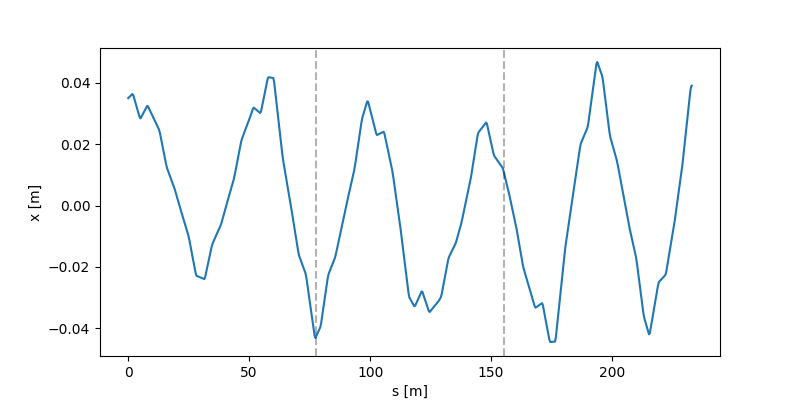

In [15]:
# Plot s vs x for the three last turns

plt.close('all')
plt.figure(figsize=(8,4))
plt.plot(s,rec_x)
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.axvline(line.get_length(), ls="--", color="k", alpha=0.3)
plt.axvline(2*line.get_length(), ls="--", color="k", alpha=0.3)